<a href="https://colab.research.google.com/github/mmsamiei/MS-Thesis-Phase3/blob/master/Models/Boroujerdi/Boroujerdi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#In the name of God

In [1]:
import IPython
from google.colab import output

display(IPython.display.Javascript('''
  function ClickConnect(){
    console.log("Working"); 
    document.querySelector("colab-connect-button").click() 
  }
  var connect_timer = setInterval(ClickConnect,60000)
'''))

print("Done.")

<IPython.core.display.Javascript object>

Done.


In [2]:
!nvidia-smi

Thu Jun 11 10:51:52 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
!pip -q install transformers

     |████████████████████████████████| 675kB 2.6MB/s 
     |████████████████████████████████| 890kB 12.9MB/s 
     |████████████████████████████████| 1.1MB 17.4MB/s 
     |████████████████████████████████| 3.8MB 22.3MB/s 


In [0]:
from torch.utils.data import Dataset, DataLoader
import os
import torch
import json
from torch.utils.data.sampler import SubsetRandomSampler
from transformers import AutoTokenizer
import random
import pandas as pd
import logging
import os

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
from transformers import AutoModel

# Dataset

In [0]:
train_file = '/content/drive/My Drive/Thesis/phase-3/hkr_train.csv'
valid_file =  '/content/drive/My Drive/Thesis/phase-3/hkr_valid.csv'

In [7]:
tokenizer = AutoTokenizer.from_pretrained('google/bert_uncased_L-2_H-128_A-2')

In [0]:
df = pd.read_csv(train_file)

In [9]:
df

,Unnamed: 0,history,knowledge,response
0,0,Science fiction,Science fiction (often shortened to SF or sci-...,I think science fiction is an amazing genre fo...
1,1,Science fiction [SEP] I think science fiction ...,Science fiction films have often been used to ...,Awesome! I really love how sci-fi storytellers...
2,2,Science fiction [SEP] I think science fiction ...,The central premise for these stories oftentim...,"It's not quite sci-fi, but my favorite version..."
3,3,Science fiction [SEP] I think science fiction ...,Science fiction often explores the potential c...,If you really want a look at the potential neg...
4,4,Science fiction [SEP] I think science fiction ...,no_passages_used,It blends science fiction and paranormal/psych...
...,...,...,...,...
41484,41484,Beard [SEP] These days I am trying to grow a b...,The Egyptian priest class ritualistically remo...,Have you considered head shaving as well? Just...
41485,41485,Collie,The collie is a distinctive type of herding do...,Have you ever heard of the Collie dog? Its a h...
41486,41486,Collie [SEP] Have you ever heard of the Collie...,The Border Collie is a working and herding dog...,"One of my favorites is the Border Collie, whic..."
41487,41487,Collie [SEP] Have you ever heard of the Collie...,Their ability to be trained to act on the soun...,I prefer collies cause they can be trained and...


In [0]:
class MyDataset(Dataset):
    """My dataset."""

    def __init__(self, csv_file, frac=1, split_rate=1, bound=False, max_len=512):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
        """
        self.dialogues = pd.read_csv(csv_file)
        self.dialogues.dropna(inplace=True)
        if bound:
          self.dialogues = self.dialogues[(self.dialogues['history'].apply(len)<280) 
          & (self.dialogues['history'].apply(len)<280) 
          & (self.dialogues['knowledge'].apply(len)<280)]
        
        self.dialogues = self.dialogues[self.dialogues.index % split_rate == 0]

        self.dialogues = self.dialogues.sample(frac=frac)
        
        # s = (self.dialogues.true_sentence.str.len() + self.dialogues.history.str.len()).sort_values().index
        # self.dialogues = self.dialogues.reindex(s)
        # s = (self.dialogues.false_sentence.str.len() + self.dialogues.history.str.len()).sort_values().index
        # self.dialogues = self.dialogues.reindex(s)


        self.dialogues.dropna(inplace=True)

        self.max_len = max_len


    def __len__(self):
        return len(self.dialogues)

    @staticmethod
    def truncuate_join_pair_sentence(sentence1, sentence2, max_len=510):

        """
        truncuate sentence one from head and sentence two from tail
        Args:
            sentence1 (string): first sentence
            sentence2 (string): seconde sentence
        """
        temp1 = tokenizer.encode(sentence1,add_special_tokens=False)
        temp2 = tokenizer.encode(sentence2,add_special_tokens=False)
        ### two above line may cause warning but no problem because we've handle them below
        logging.getLogger("transformers.tokenization_utils").setLevel(logging.ERROR)
        seq_1 = temp1
        seq_2 = temp2
        num_tokens_to_remove = len(temp1) + len(temp2) + 3 - max_len
        if num_tokens_to_remove > 0 :
            seq_1, seq_2, _ = tokenizer.truncate_sequences(temp1[::-1],temp2, num_tokens_to_remove=num_tokens_to_remove)
            seq_1.reverse()
        result_list = [tokenizer.cls_token_id]+seq_1+[tokenizer.sep_token_id]+seq_2+[tokenizer.sep_token_id]
        token_type_ids = [0] * (len(seq_1) + 2) + [1] * (len(seq_2) + 1)
        return result_list, token_type_ids


    def __getitem__(self, idx):
      
        
        history = self.dialogues.iloc[idx].history
        knowledge = self.dialogues.iloc[idx].knowledge
        response = self.dialogues.iloc[idx].response


        input_pair, input_pair_segments = MyDataset.truncuate_join_pair_sentence(history, knowledge, self.max_len)
                

        input_pair = torch.LongTensor(input_pair)

        input_pair_segments = torch.LongTensor(input_pair_segments)

        response_tensor = torch.LongTensor(tokenizer.encode(response))

        sample = {'input_pair': input_pair,
                  'input_pair_segments': input_pair_segments,
                  'response': response_tensor}

        return sample


In [11]:
train_dataset = MyDataset(train_file, max_len=128)
valid_dataset = MyDataset(valid_file, max_len=510)
print(len(train_dataset))
print(len(valid_dataset))

41489
2294


In [12]:
tokenizer.decode(train_dataset[0]['input_pair'])
tokenizer.decode(train_dataset[0]['response'])

'[CLS] i really like their health and fit products, they actually use real ingredients and it tastes good as well [SEP]'

In [16]:
from tqdm.auto import tqdm

def my_collate_fn(batch):

  len_batch = len(batch)

  
  max_len_input_pair = max([len(data['input_pair']) for data in batch])

  max_len_response = max([len(data['response']) for data in batch])
  
  padding_ind = 0 ## for bert is 0 DON'T THINK BAD IT IS NOT REFACTORING !!!!!!
  result_input_pair = torch.zeros(len_batch, max_len_input_pair)
  result_input_pair_segments = torch.zeros(len_batch, max_len_input_pair)
  result_response = torch.zeros(len_batch, max_len_response)

  for i, data in enumerate(batch):
    p1 = len(data['input_pair'])
    result_input_pair[i, :p1] = data['input_pair']

    p3 = len(data['input_pair_segments'])
    result_input_pair_segments[i, :p3] = data['input_pair_segments']

    p4 = len(data['response'])
    result_response[i, :p4] = data['response']

  return result_input_pair.long(), result_input_pair_segments.long(), result_response.long()

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64,
                                             shuffle=True, collate_fn=my_collate_fn,
                                           num_workers=1)

valid_sampler = torch.utils.data.SequentialSampler(valid_dataset)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=64, sampler=valid_sampler,
                                             shuffle=False, collate_fn=my_collate_fn, num_workers=1)

i = 0 
for batch_idx, batch  in tqdm(enumerate(train_loader)):
  pair_batch, segment_batch, response_batch = batch
  print(pair_batch.shape)
  print(segment_batch.shape)
  print(response_batch.shape)
  print("****")
  i += 1 
  if(i==2):
    break

print(len(train_loader))
print(len(valid_loader))

torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 42])
****
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 62])
****
649
36


# Model

In [0]:
from transformers import EncoderDecoderModel, BertTokenizer

class Model(nn.Module):
  def __init__(self):
    super(Model, self).__init__()

    self.seq2seq = EncoderDecoderModel.from_encoder_decoder_pretrained(
        'google/bert_uncased_L-2_H-128_A-2', 'google/bert_uncased_L-2_H-128_A-2')
    
    for p in self.seq2seq.encoder.embeddings.parameters():
      p.requires_grad = False
    
    for p in self.seq2seq.decoder.bert.embeddings.parameters():
      p.requires_grad = False

  def forward(self, encoder_input, segments_tensors, decoder_input):
    '''
    encoder_input = [batch_size, enc_len]
    segments_tensors = [batch_size, enc_len]
    decoder_input = [batch_size, dec_len]
    '''
    kwargs = {'token_type_ids':segments_tensors}
    outputs = self.seq2seq(input_ids=encoder_input, decoder_input_ids=decoder_input, **kwargs)[0]
    return outputs
  
  def generate(self, encoder_input, segments_tensors):
    kwargs = {'token_type_ids':segments_tensors}
    generated = model.seq2seq.generate(encoder_input, decoder_start_token_id=101, **kwargs) ## [CLS] = 101
    return generated

In [84]:
dev = torch.device('cuda')
model = Model().to(dev)

# x = torch.LongTensor(200, 40).random_(1,1000).to(dev)
# print(model(x).shape)


def count_parameters(model): return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(count_parameters(model))

1006010


#Optimizer



In [0]:
class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return self.factor * \
            (self.model_size ** (-0.5) *
            min(step ** (-0.5), step * self.warmup ** (-1.5)))
    
    def zero_grad(self):
        self.optimizer.zero_grad()

In [0]:
optimizer2 = NoamOpt(128, 1, 2000,
            torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))
optimizer = NoamOpt(128, 0.5, 2000,
            torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))
#optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

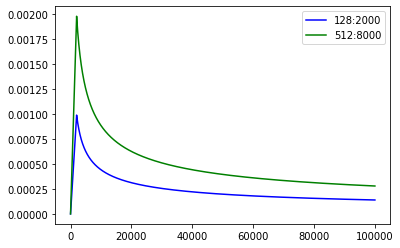

In [86]:
import matplotlib.pyplot as plt
import numpy as np
plt.plot(np.arange(1, 100000), [optimizer.rate(i) for i in range(1, 100000)], color='blue')
plt.plot(np.arange(1, 100000), [optimizer2.rate(i) for i in range(1, 100000)], color='green')
plt.legend(["128:2000", "512:8000", "256:4000"])

# Training

In [0]:
import torch.nn

def mahdi_loss(model_output, true_trg):
  '''
  model_output: [batch, len, hidden]
  true_trg: [batch, len]
  '''
  batch_len = model_output.shape[0]
  snt_len = model_output.shape[1]
  hidden_size = model_output.shape[2]

  model_output = model_output.reshape(-1, hidden_size)
  true_trg = true_trg.reshape(-1)

  loss_mod = nn.CrossEntropyLoss(ignore_index=0)## PAD = 0
  loss = loss_mod(model_output, true_trg)
  return loss

In [0]:
from tqdm.auto import tqdm

def train_step(batch_idx, batch):
  pair_batch, segment_batch, response_batch = batch
  pair_batch = pair_batch.to(dev)
  segment_batch = segment_batch.to(dev)
  response_batch = response_batch.to(dev)
  model_output = model(pair_batch, segment_batch, response_batch)
  loss = mahdi_loss(model_output, response_batch)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  del pair_batch
  del segment_batch
  del response_batch
  return loss.item()

def valid_step(batch_idx, batch):
  with torch.no_grad():
    pair_batch, segment_batch, response_batch = batch
    pair_batch = pair_batch.to(dev)
    segment_batch = segment_batch.to(dev)
    response_batch = response_batch.to(dev)
    model_output = model(pair_batch, segment_batch, response_batch)
    loss = mahdi_loss(model_output, response_batch)
    del pair_batch
    del segment_batch
    del response_batch
    return loss.item()

def valid_loop(valid_loader):
  total_loss = 0
  model.eval()
  for batch_idx, batch in tqdm(enumerate(valid_loader),  total=len(valid_loader)):
    total_loss += valid_step(batch_idx, batch)
  print(total_loss)
  return total_loss / len(valid_dataset)

In [0]:
new_learning = True
if new_learning:
  # optimizer = NoamOpt(128, 1, 2000,
  #           torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))
  model_dir = "/content/drive/My Drive/Thesis/phase-3/Models/Boroujerdi/"
  step = 0
  log_list = []

In [0]:
## if continue learning:
#!wget -q https://github.com/mmsamiei/MS-Thesis-Phase2/raw/master/Models/hashemi_16000steps.model
model_dir = "/content/drive/My Drive/Thesis/phase-3/Models/Boroujerdi"
checkpoint = torch.load(model_dir+'boroujerdi_25000steps.model')
step = checkpoint['log_list'][-1]['step']
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
optimizer._step = step
log_list = checkpoint['log_list']
new_learning = False
print(step)

In [0]:
from tqdm.auto import tqdm

MAX_STEP = 10000
STEP_SAVE = 100
STEP_CHECK = 500
step_num = step + 1
log_list = log_list ### Check if new learning or not
print(step_num)
while step_num <= MAX_STEP:
  model.train()
  for batch_idx, batch in tqdm(enumerate(iter(train_loader)), total=len(train_loader)):
    step_loss = train_step(batch_idx, batch)
    log = {'step':step_num, 'train_loss':step_loss}
    if(step_num % STEP_CHECK == 0):
      valid_error = valid_loop(valid_loader)
      print("Loss rate: {} at step {}".format(valid_error, step_num))  
      log['valid_loss'] = valid_error
      log_list.append(log)
      model.train()
      torch.save({
            'model_state_dict': model.state_dict(),
            'log_list': log_list,
            'optimizer_state_dict': optimizer.optimizer.state_dict() 
            }, model_dir+'boroujerdi_{}steps.model'.format(step_num))
      step_num += 1
      continue
    
    log_list.append(log)
    if(step_num % STEP_SAVE == 0):
      torch.save({
            'model_state_dict': model.state_dict(),
            'log_list': log_list,
            'optimizer_state_dict': optimizer.optimizer.state_dict()
            }, model_dir+'boroujerdi_{}steps.model'.format(step_num))
    step_num += 1

1


In [27]:
log_list

[{'step': 1, 'train_loss': 4.573500633239746},
 {'step': 2, 'train_loss': 4.6115217208862305},
 {'step': 3, 'train_loss': 4.456216335296631},
 {'step': 4, 'train_loss': 4.73253059387207},
 {'step': 5, 'train_loss': 4.493163585662842},
 {'step': 6, 'train_loss': 4.529580593109131},
 {'step': 7, 'train_loss': 4.4646735191345215},
 {'step': 8, 'train_loss': 4.375193119049072},
 {'step': 9, 'train_loss': 4.327970504760742},
 {'step': 10, 'train_loss': 4.130836486816406},
 {'step': 11, 'train_loss': 4.174636363983154},
 {'step': 12, 'train_loss': 4.1171674728393555},
 {'step': 13, 'train_loss': 4.341594219207764},
 {'step': 14, 'train_loss': 3.976616859436035},
 {'step': 15, 'train_loss': 4.0958733558654785},
 {'step': 16, 'train_loss': 4.037125110626221},
 {'step': 17, 'train_loss': 3.89686918258667},
 {'step': 18, 'train_loss': 3.7523674964904785},
 {'step': 19, 'train_loss': 3.707036256790161},
 {'step': 20, 'train_loss': 3.436854600906372},
 {'step': 21, 'train_loss': 3.627664089202881}

In [0]:
loss = nn.CrossEntropyLoss()
input = torch.randn(3, 5, requires_grad=True)
target = torch.empty(3, dtype=torch.long).random_(5)
output = loss(input, target)
print(output)
output.backward()

tensor(1.5508, grad_fn=<NllLossBackward>)
